<a href="https://colab.research.google.com/github/Sssunithaaa/ImageProcessing/blob/main/noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Processing /content/drive/My Drive/Data/0178_008_S6_01600_00400_5500_L/GT_SRGB_010.PNG
PSNR: 27.68 dB
SSIM: 0.0209


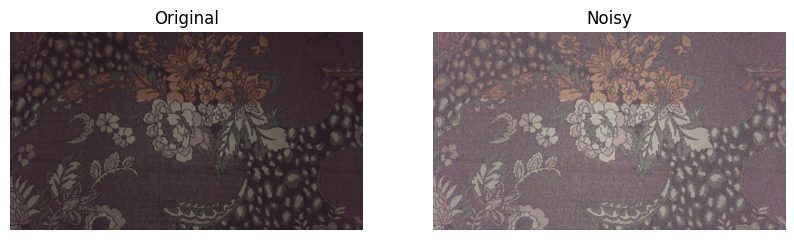

Processing /content/drive/My Drive/Data/0177_008_S6_00800_00200_5500_L/GT_SRGB_010.PNG
PSNR: 27.69 dB
SSIM: 0.0207


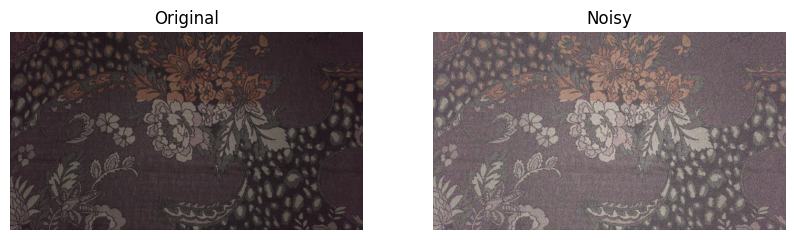

Processing /content/drive/My Drive/Data/0197_009_IP_00100_00200_5500_L/GT_SRGB_010.PNG
PSNR: 27.91 dB
SSIM: 0.0050


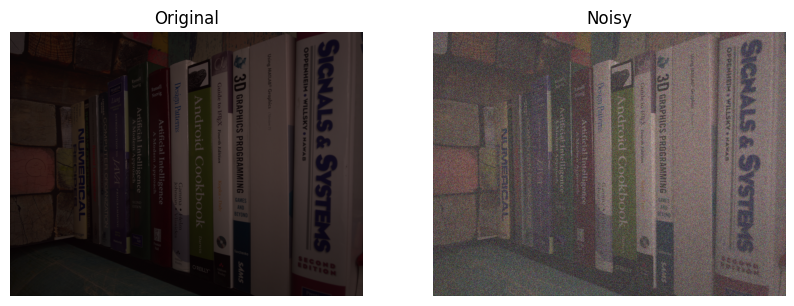

Processing /content/drive/My Drive/Data/0193_009_IP_00800_02000_3200_N/GT_SRGB_010.PNG
PSNR: 27.75 dB
SSIM: 0.0063


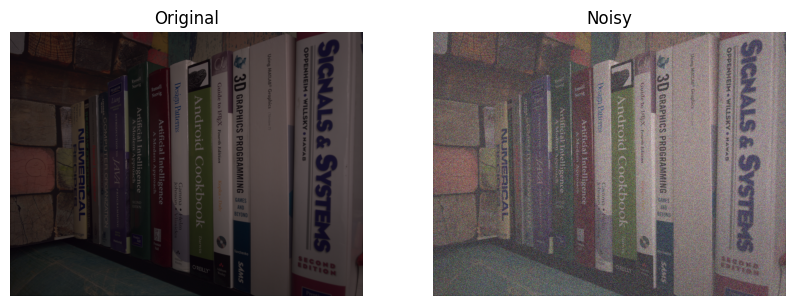

Processing /content/drive/My Drive/Data/0198_010_GP_00100_00200_5500_N/GT_SRGB_010.PNG
PSNR: 27.95 dB
SSIM: 0.0131


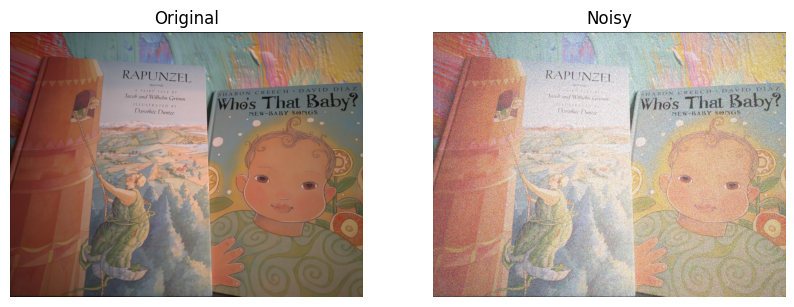

In [7]:
import os
import numpy as np
from scipy.stats import poisson
import cv2
import matplotlib.pyplot as plt

def psnr(original, noisy):
    mse = np.mean((original - noisy) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

def ssim(original, noisy):
    C1 = (0.01 * 255) ** 2
    C2 = (0.03 * 255) ** 2

    original = original.astype(np.float64)
    noisy = noisy.astype(np.float64)

    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(original, -1, window)[5:-5, 5:-5]
    mu2 = cv2.filter2D(noisy, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(original ** 2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(noisy ** 2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(original * noisy, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    ssim_value = ssim_map.mean()

    return ssim_value

def add_poisson_gaussian_noise(image, sigma_read, total_gain, noise_scale=1.0, poisson_scale=1.0):
    image = np.clip(image.astype(np.float32) / 255.0, 0.0, 1.0)
    channels = np.split(image, 3, axis=2)

    noisy_channels = []
    for channel in channels:
        photon_counts = channel * total_gain
        shot_noise = poisson.rvs(photon_counts) / total_gain
        shot_noise *= poisson_scale
        read_noise = np.random.normal(loc=0.0, scale=sigma_read, size=channel.shape)
        noisy_channel = shot_noise + read_noise * noise_scale
        noisy_channels.append(noisy_channel)

    noisy_image = np.clip(np.dstack(noisy_channels), 0.0, 1.0)
    return (noisy_image * 255).astype(np.uint8)

def add_salt_and_pepper_noise(image, salt_prob, pepper_prob):
    noisy_image = np.copy(image)
    num_salt = np.ceil(salt_prob * image.size)
    num_pepper = np.ceil(pepper_prob * image.size)

    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    noisy_image[coords[0], coords[1], :] = 255

    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    noisy_image[coords[0], coords[1], :] = 0

    return noisy_image

def add_combined_noise(image, sigma_read, total_gain, noise_scale, poisson_scale, salt_prob, pepper_prob):
    noisy_image = add_poisson_gaussian_noise(image, sigma_read, total_gain, noise_scale, poisson_scale)
    noisy_image = add_salt_and_pepper_noise(noisy_image, salt_prob, pepper_prob)
    return noisy_image

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

sigma_read = 0.1
total_gain = 500.0
noise_scale = 5.0
poisson_scale = 2.0
salt_prob = 0.02
pepper_prob = 0.02

dataset_folder = "/content/drive/My Drive/Data"
plot_count = 0
max_plots = 5

if not os.path.exists(dataset_folder):
    print(f"Error: The folder {dataset_folder} does not exist.")
else:
    for root, _, files in os.walk(dataset_folder):
        for file in files:
            if file.startswith('GT_SRGB_010') and file.endswith('.PNG'):
                image_path = os.path.join(root, file)
                print(f"Processing {image_path}")

                image = cv2.imread(image_path)
                if image is None:
                    print(f"Error: Failed to read image {image_path}")
                    continue

                noisy_image = add_combined_noise(image, sigma_read, total_gain, noise_scale, poisson_scale, salt_prob, pepper_prob)

                psnr_value = psnr(image, noisy_image)
                ssim_value = ssim(image, noisy_image)

                print(f"PSNR: {psnr_value:.2f} dB")
                print(f"SSIM: {ssim_value:.4f}")

                if plot_count < max_plots:
                    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
                    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                    axes[0].set_title('Original')
                    axes[0].axis('off')
                    axes[1].imshow(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))
                    axes[1].set_title('Noisy')
                    axes[1].axis('off')

                    plt.show()
                    plot_count += 1

                if plot_count >= max_plots:
                    break
        if plot_count >= max_plots:
            break
